In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19_bn
from torchvision.models import VGG19_BN_Weights
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm

In [ ]:
class DS(Dataset):
    def __init__(self,data_dir,transform=None):
        self.data = ImageFolder(root = data_dir,transform=transform)
    def __len__(self):
        return len(self.data)
    def __getitem___(self,idx):
        return self.data[idx]
    @property
    def classes(self):
        return self.data.classes

In [3]:
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
transform_vgg = VGG19_BN_Weights.IMAGENET1K_V1.transforms()

In [8]:

class DogCatClassifier(nn.Module):
    def __init__(self):
        super(DogCatClassifier,self).__init__()
        self.base_model = vgg19_bn(weights = VGG19_BN_Weights.DEFAULT)
        #self.base_model = vgg19_bn()
        #self.base_model = timm.create_model('efficientnet_b0',pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
         # Pass a dummy tensor through features to get the output shape
        #dummy_input = torch.randn(1, 3, 224, 224)  # assuming input size of 224x224
        #vgg_out = self.features(dummy_input).view(1, -1).size(1)
        #print(vgg_out)
        self.classify = nn.Sequential(nn.Linear(25088,2))
        #self.classify = nn.Sequential(nn.Linear(1280,2))
    def forward(self,X):
        #print(X.shape)
        X = self.features(X)
        #print(X.shape)
        X = torch.flatten(X,1)
        return self.classify(X)
        

In [9]:
class FilteredImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(FilteredImageFolder, self).__init__(root, transform=transform)
        
    def __getitem__(self, index):
        try:
            path, target = self.samples[index]
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            return sample, target
        except UnidentifiedImageError:
            # Skip the corrupted image
            return self.__getitem__((index + 1) % len(self.samples))

In [10]:
dataset = FilteredImageFolder(root='/kaggle/input/microsoft-catsvsdogs-dataset/PetImages',transform =transform_vgg)
image,label = dataset[1]
label

0

In [ ]:
errors = 0
for image,label in dataset:
    if image is None:
        errors+=1
errors

In [11]:
l = len(dataset)
train_len = int(l*.7)
valid_len = int(l*.2)
test_len = l-train_len-valid_len

train_ds,temp = random_split(dataset,[train_len,valid_len+test_len])
valid_ds,test_ds = random_split(temp,[valid_len,test_len])
image,label = train_ds[1035]

0


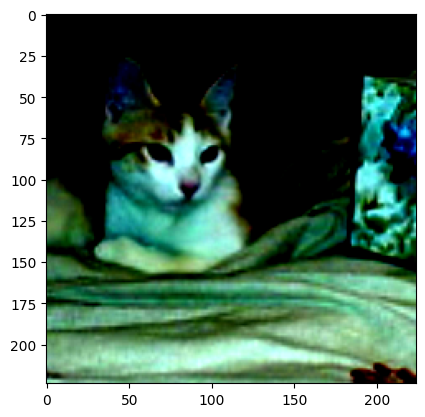

In [12]:
iimg = image.permute(1,2,0).numpy()
plt.imshow(iimg)
print(label)

In [13]:
train_loader = DataLoader(train_ds,batch_size=32,shuffle=True)
valid_loader = DataLoader(valid_ds,batch_size=32,shuffle=False)
test_loader = DataLoader(test_ds,batch_size=32,shuffle=False)

In [ ]:
model = DogCatClassifier()
c = nn.CrossEntropyLoss()
for images,labels in train_loader:
    print(images.shape)
    out = model(images)
    print(c(out,labels))
    break

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_losses,valid_losses = [],[]
epochs = 5

model = DogCatClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = .001)
model = model.to(device)

for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for images,labels in tqdm(train_loader):
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out,labels)
        loss.backward()
        
        optimizer.step() #update model weights
        
        running_loss += len(labels)*loss.item()
    train_losses.append(running_loss/len(train_ds))
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images,labels in tqdm(valid_loader):
            images,labels = images.to(device),labels.to(device)
            out = model(images)
            loss = criterion(out,labels)
            running_loss += loss.item()*len(labels)
        valid_losses.append(running_loss/len(valid_ds))
    print(f"Epoch {epoch}/5 - Train Loss: {train_losses[epoch]} - Valid Loss: {valid_losses[epoch]}")
        
        

In [ ]:
checkpoint = {
    'model':DogCatClassifier(),
    'state_dict':model.state_dict(),
    'optimizer':optimizer.state_dict()
}
torch.save(checkpoint,'checkpoint.pth')

In [15]:
model_dict = torch.load('/kaggle/input/dogcatclassifiertrained/pytorch/default/1/checkpoint.pth')
model_f = DogCatClassifier()
model_f.load_state_dict(model_dict['state_dict'])
model_f.eval()

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:03<00:00, 163MB/s]  


DogCatClassifier(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, p

In [28]:
model.to(device)
accuracy_list = []
for images,labels in test_loader:
    images,labels = images.to(device),labels.to(device)
    output = model_f(images)
    out = torch.argmax(output,dim=1)
    accuracy = np.mean((out==labels).numpy())
    accuracy_list.append(accuracy)
print(np.mean(accuracy_list))

0.9375
0.9375
1.0
0.96875
0.90625
1.0
0.90625
1.0
0.90625
1.0
1.0
0.90625
0.875
0.875
0.96875
0.90625
0.9375
1.0
0.875
0.9375
0.9375
0.96875
1.0
0.90625
0.90625
1.0
0.90625
0.90625
0.96875
0.96875
0.96875
0.875
0.90625
0.9375
1.0
0.9375
0.90625
0.875
0.9375
0.9375
1.0
0.9375
0.9375
0.96875
1.0
0.96875
0.96875
0.96875
0.875
0.90625
0.875
0.96875
0.90625
1.0
0.9375
0.875
0.9375
0.96875
0.96875
0.90625
0.90625
0.9375
0.96875
0.9375
0.8125
0.84375
0.9375
0.9375
0.9375
0.84375
0.9375
0.84375
0.9375
0.96875
0.84375
0.96875
0.9375
0.96875
1.0
0.9359177215189873
